In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
df = pd.read_csv("archive (1)/Bengaluru_House_Data.csv")

In [137]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [138]:
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [139]:
df.drop(['society','balcony', 'availability', 'area_type'], axis=1, inplace = True)

In [140]:
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [141]:
df2 = df.dropna().copy()

In [142]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [143]:
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [144]:
df2.drop('size', inplace=True, axis=True)

In [145]:
def to_float(row):
    token = row.split('-')
    if len(token) == 2:
        return (float(token[0]) + float(token[1]))* 0.5
    try:
        return float(row)
    except:
        return None

In [146]:
df2['total_sqft'] = df2['total_sqft'].apply(to_float)

In [147]:
df2['location'] = df2['location'].apply(lambda x: x.strip())
df2.dropna(inplace=True)

In [148]:
location_stats = df2.groupby('location')['location'].count().sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats<10]

In [149]:
df2['location'] = df2['location'].apply(lambda x: 'Other' if x in location_stats_less_than_10 else x)

In [177]:
df2 = df2[df2['bhk']<10]

In [178]:
len(df2['location'].unique())

255

In [151]:
df2.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [152]:
df2['price_per_sqft'] = (df2['price']*100000)/ df2['total_sqft']

In [153]:
df2.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [154]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price)
        std = np.std(subdf.price)
        reduced_df = subdf[((subdf.price >= (m-std)) & (subdf.price <= (m+std)))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [155]:
len(df2)

13200

In [156]:
df2 = remove_pps_outliers(df2)
df2.shape 

(11309, 6)

In [157]:
def remove_outlier_bhk(df):  
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [158]:
df2 = remove_outlier_bhk(df2)
df2.shape

(7718, 6)

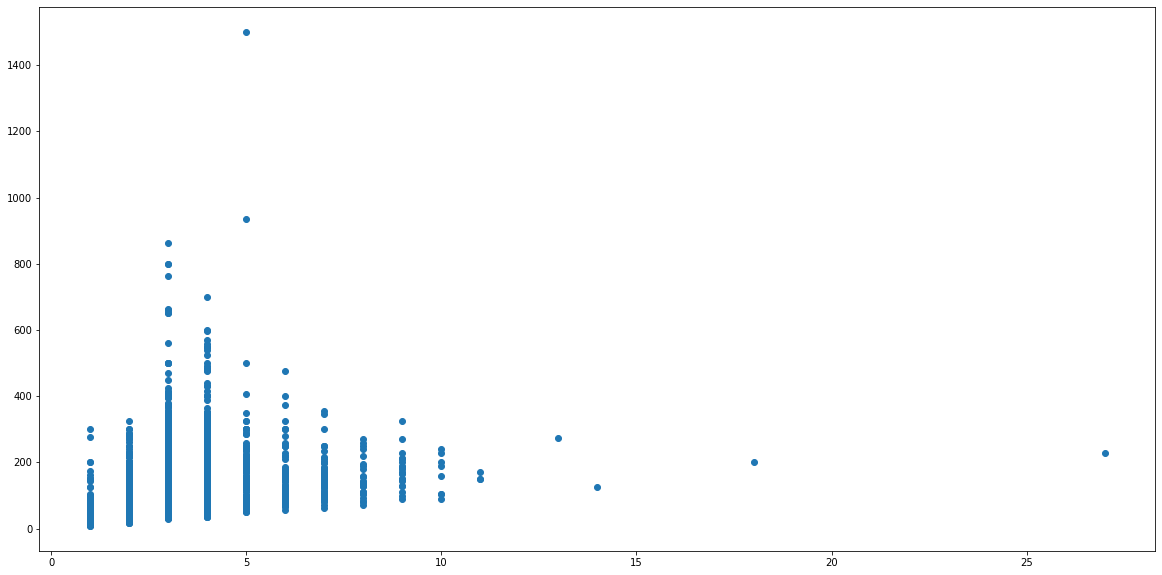

In [176]:
plt.scatter(df2.bhk, df2.price)